In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tweets-about-the-top-companies-from-2015-to-2020/Company_Tweet.csv
/kaggle/input/tweets-about-the-top-companies-from-2015-to-2020/Tweet.csv
/kaggle/input/tweets-about-the-top-companies-from-2015-to-2020/Company.csv


In [2]:
# Import packages

import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from nltk.corpus import stopwords
from nltk.util import ngrams

from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import classification_report,confusion_matrix

from collections import defaultdict
from collections import Counter
plt.style.use('ggplot')
stop=set(stopwords.words('english'))

import re
from nltk.tokenize import word_tokenize
import gensim
import string

from tqdm import tqdm
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM,Dense, SpatialDropout1D, Dropout
from keras.initializers import Constant


import torch

import warnings
warnings.simplefilter('ignore')

In [3]:
ct= pd.read_csv('/kaggle/input/tweets-about-the-top-companies-from-2015-to-2020/Company_Tweet.csv')
tweet=pd.read_csv('/kaggle/input/tweets-about-the-top-companies-from-2015-to-2020/Tweet.csv')
company = pd.read_csv('/kaggle/input/tweets-about-the-top-companies-from-2015-to-2020/Company.csv')

In [4]:
print('There are {} rows and {} columns in tweet'.format(tweet.shape[0],tweet.shape[1]))

There are 3717964 rows and 7 columns in tweet


In [5]:
tweet.head()

,tweet_id,writer,post_date,body,comment_num,retweet_num,like_num
0,550441509175443456,VisualStockRSRC,1420070457,"lx21 made $10,008 on $AAPL -Check it out! htt...",0,0,1
1,550441672312512512,KeralaGuy77,1420070496,Insanity of today weirdo massive selling. $aap...,0,0,0
2,550441732014223360,DozenStocks,1420070510,S&P100 #Stocks Performance $HD $LOW $SBUX $TGT...,0,0,0
3,550442977802207232,ShowDreamCar,1420070807,$GM $TSLA: Volkswagen Pushes 2014 Record Recal...,0,0,1
4,550443807834402816,i_Know_First,1420071005,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1


In [6]:
# EDA

def length(text):    
    '''a function which returns the length of text'''
    return len(text)

tweet['length'] = tweet['body'].apply(length)

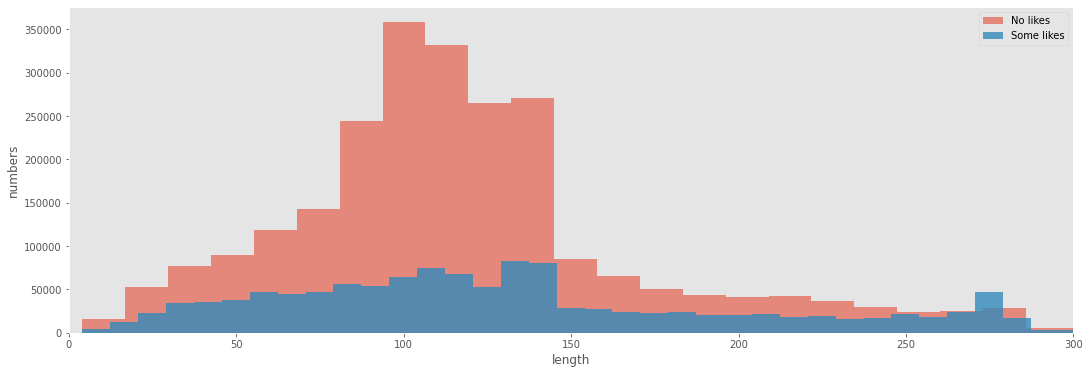

In [7]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
bins = 300
plt.hist(tweet[tweet['like_num'] == 0]['length'], alpha = 0.6, bins=bins, label='No likes')
plt.hist(tweet[tweet['like_num'] > 0]['length'], alpha = 0.8, bins=bins, label='Some likes')
plt.xlabel('length')
plt.ylabel('numbers')
plt.legend(loc='upper right')
plt.xlim(0,300)
plt.grid()
plt.show()

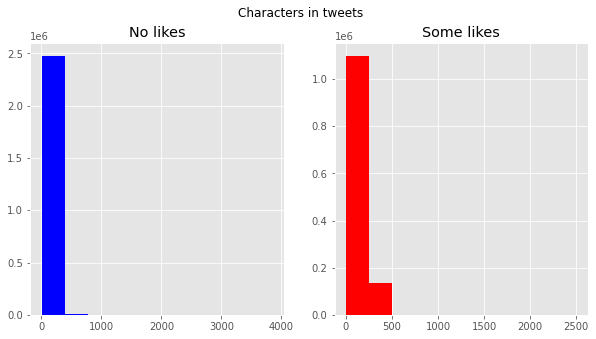

In [8]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=tweet[tweet['like_num']==0]['body'].str.len()
ax1.hist(tweet_len,color='blue')
ax1.set_title('No likes')
tweet_len=tweet[tweet['like_num']>0]['body'].str.len()
ax2.hist(tweet_len,color='red')
ax2.set_title('Some likes')
fig.suptitle('Characters in tweets')
plt.show()

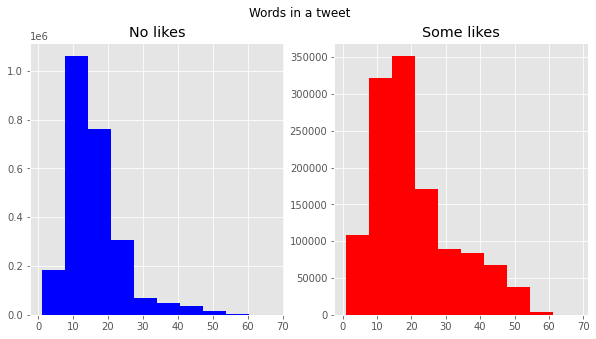

In [9]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=tweet[tweet['like_num'] == 0]['body'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='blue')
ax1.set_title('No likes')
tweet_len=tweet[tweet['like_num'] > 0]['body'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='red')
ax2.set_title('Some likes')
fig.suptitle('Words in a tweet')
plt.show()

Text(0.5, 0.98, 'Average word length in each tweet')

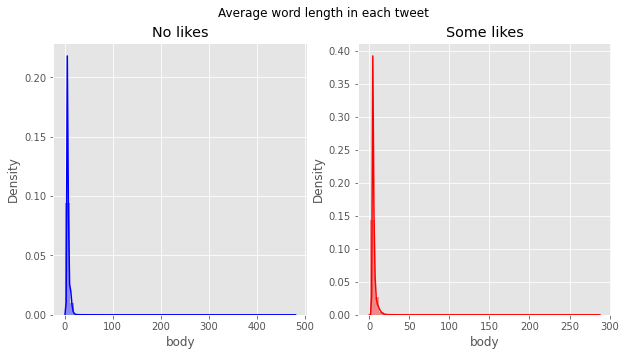

In [10]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word=tweet[tweet['like_num']==0]['body'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='blue')
ax1.set_title('No likes')
word=tweet[tweet['like_num'] > 0]['body'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='red')
ax2.set_title('Some likes')
fig.suptitle('Average word length in each tweet')

In [11]:
corpus = []

for x in tweet['body'].str.split():
    for i in x:
        corpus.append(i)
    

In [12]:
dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

In [13]:
# displaying the stopwords
np.array(stop)

array({"couldn't", 'hadn', "she's", "should've", "it's", "weren't", 'there', 'you', 'through', 'y', 'with', 'such', 'how', 'more', 'until', 'has', 'they', 'to', 'too', 'is', 'mightn', 'ourselves', 'so', "that'll", 'myself', 'into', "shan't", 'some', 'up', 'be', 'against', 'wasn', 'shan', 'this', 'at', 'then', 'his', 'she', 'our', 'who', 'ours', 'herself', 'same', 'during', 'here', 're', "you've", 'than', 'now', 'a', 'own', 'off', 'him', 'that', 'further', 'ain', 'your', 'whom', 'mustn', 'o', 'had', 'them', 'each', "wouldn't", "hadn't", 'these', 'down', 'ma', 'it', 'will', 'their', "you'd", 'yourself', "hasn't", 'after', 'very', 'and', 've', 'other', 'do', 'from', 'itself', 'all', 'what', "you're", 'just', 'my', "aren't", 'those', 'below', "needn't", 'of', 'themselves', 'if', 'm', "isn't", "shouldn't", 'we', 'her', 'didn', 'hers', 'me', 'why', 'while', 'once', 'most', 'being', 'the', 'd', 'on', 'doing', 'does', 'but', 'both', 't', 'for', 'i', 'above', 'theirs', 'when', 'having', 'not', 

<BarContainer object of 10 artists>

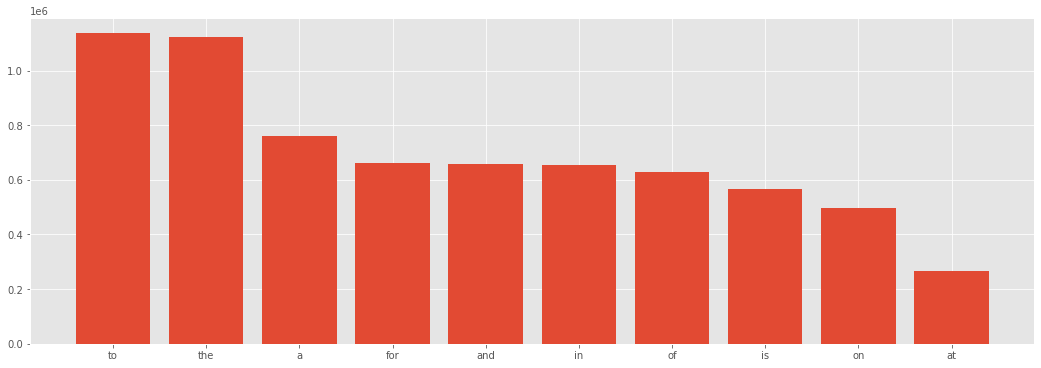

In [14]:
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]

plt.rcParams['figure.figsize'] = (18.0, 6.0)
x,y=zip(*top)
plt.bar(x,y)

<BarContainer object of 52 artists>

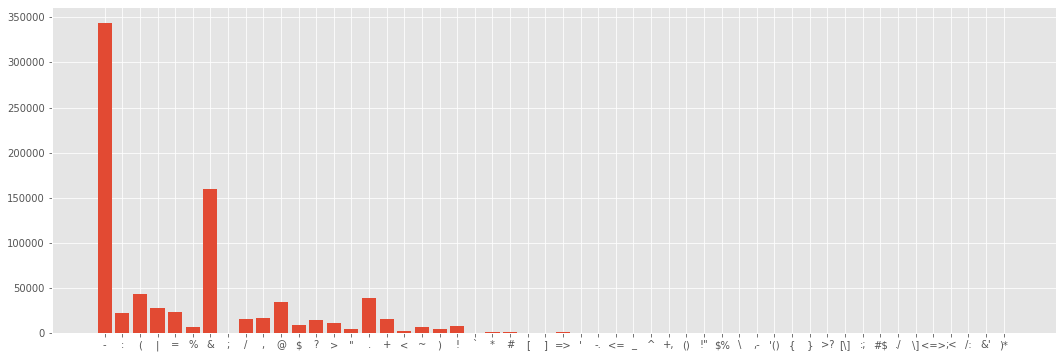

In [15]:
# Analyzing punctuation

dic=defaultdict(int)
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y)

In [16]:
# Most common words

plt.figure(figsize=(16,5))
counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:40]:
    if (word not in stop) :
        x.append(word)
        y.append(count)
        

<Figure size 1152x360 with 0 Axes>

<AxesSubplot:>

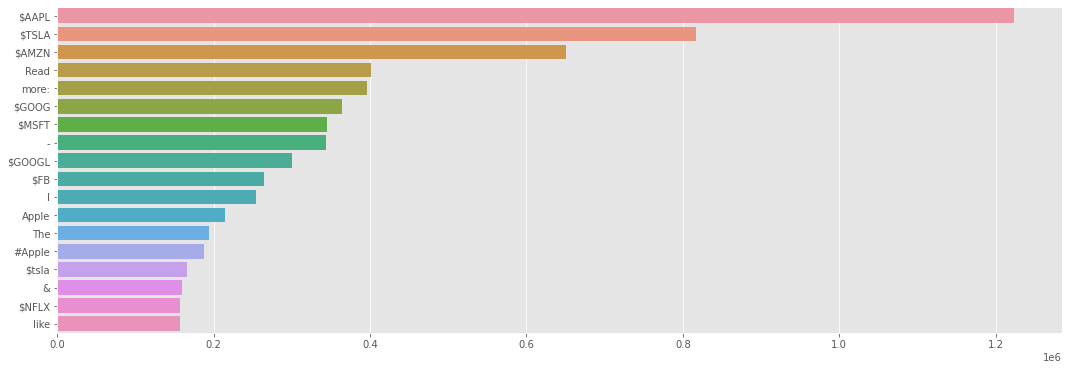

In [17]:
sns.barplot(x=y,y=x)

In [18]:
#Ngram analysis

def get_top_tweet_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

<AxesSubplot:>

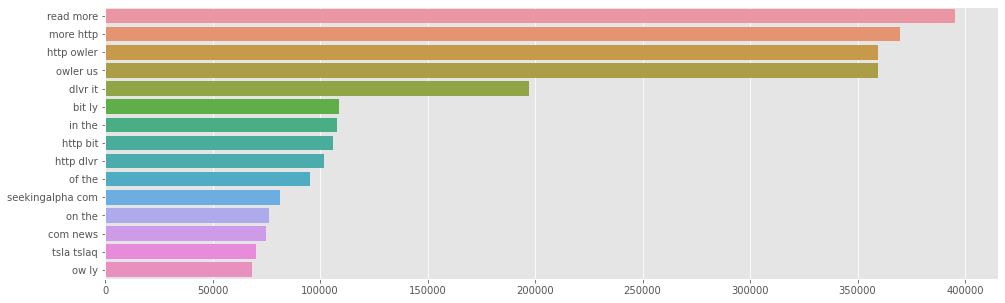

In [19]:
plt.figure(figsize=(16,5))
top_tweet_bigrams=get_top_tweet_bigrams(tweet['body'])[:15]
x,y=map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x)